<a href="https://colab.research.google.com/github/iimhonde/kmeans-vgg16-iris-vs-muffin/blob/main/STA_4724_Final_Project_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris, make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import numpy as np



Graphs to add:
- Silhouette Score vs k
-  Davies-Bouldin Index vs k
- 2D Scatter Plot of Clusters (with KMeans)
- Side-by-Side Comparison of True Labels vs Predicted Clusters (Iris)

In [ ]:
from PIL import Image
from keras.preprocessing.image import img_to_array
from icrawler.builtin import BingImageCrawler
"""
chihuahua_crawler = BingImageCrawler(storage={'root_dir': 'images/chihuahuas'})
chihuahua_crawler.crawl(keyword='blonde chihuahua face close-up', max_num=10)

muffin_crawler = BingImageCrawler(storage={'root_dir': 'images/blueberry_muffins'})
muffin_crawler.crawl(keyword='blueberry muffin high resolution', max_num=10)
"""

IMG_SIZE = (224, 224)
folders = {
    'chihuahua': 'images/chihuahuas',
    'muffin': 'images/blueberry_muffins'
}

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            try:
                img = Image.open(path).convert('RGB').resize(IMG_SIZE)
                arr = img_to_array(img)
                arr = preprocess_input(np.expand_dims(arr, axis=0))
                images.append(arr)
            except Exception as e:
                print(f"Skipped {filename}: {e}")
    return images

images = []
labels = []

for label, folder in folders.items():
    imgs = load_images_from_folder(folder)
    images.extend(imgs)
    labels.extend([label] * len(imgs))

X_imgs = np.vstack(images)  # shape = (20, 224, 224, 3)

vgg = VGG16(weights='imagenet', include_top=False, pooling='avg')
features = vgg.predict(X_imgs)  # shape = (n, 512)

# Reduce dimensionality to 20 principal components to capture most of the variance
# while minimizing noise and improving clustering performance
pca = PCA(n_components=20)
X_pca = pca.fit_transform(features)



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [ ]:
# Load real dataset (Iris)
iris_data = load_iris()
X_iris = iris_data.data
datasets = [("Iris Dataset", X_iris), ("Chihuahua vs Muffin Dataset", X_pca)]
for name, X in datasets:
    print(f" Dataset: {name}")
    print(f"🔹 Shape: {X.shape}")
    print(f"🔹 Dtype: {X.dtype}")
    print(f"🔹 NaNs? {np.isnan(X).any()}")
    print(f"🔹 Any empty rows? {np.any(np.all(X == 0, axis=1))}")
    print()

 Dataset: Iris Dataset
🔹 Shape: (150, 4)
🔹 Dtype: float64
🔹 NaNs? False
🔹 Any empty rows? False

 Dataset: Chihuahua vs Muffin Dataset
🔹 Shape: (20, 20)
🔹 Dtype: float32
🔹 NaNs? False
🔹 Any empty rows? False



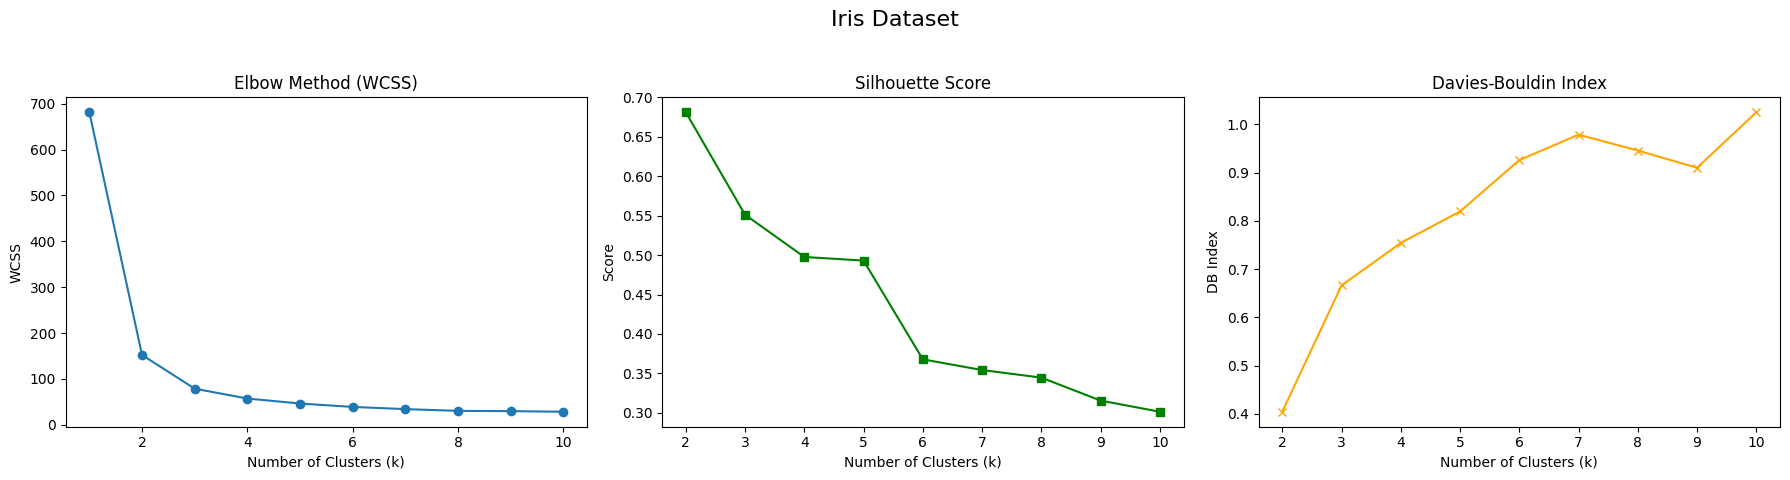

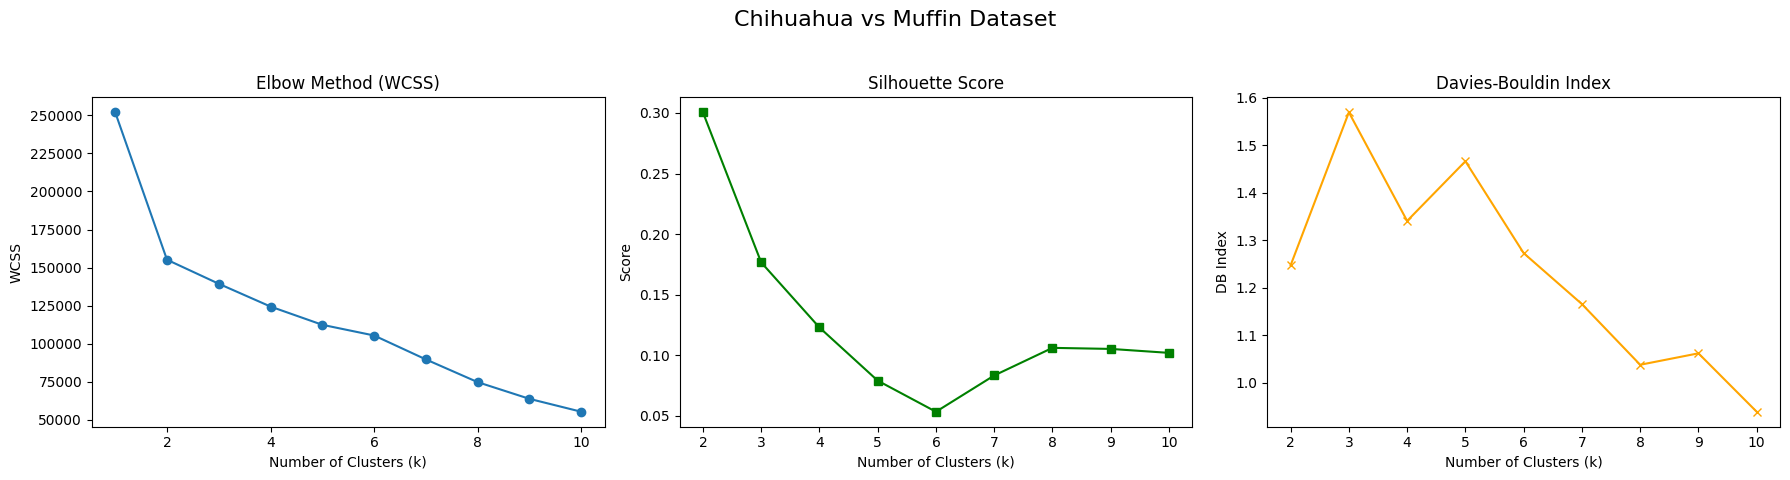

In [ ]:

all_metrics = {}
# Loop over datasets
for dataset_name, X in datasets:
    k_models = {}
    for k in range(1, 11):
        model = KMeans(n_clusters=k, random_state=42).fit(X)
        k_models[k] = model

    def euclidean_distance(a, b):
        return np.sqrt(sum((np.array(a) - np.array(b)) ** 2)) ** 2

    def wcss(points, centroids, labels):
        total_wcss = 0
        for cluster in set(labels):
            cluster_sum = 0
            for point in points[labels == cluster]:
                cluster_sum += euclidean_distance(point, centroids[cluster])
            total_wcss += cluster_sum
        return total_wcss

    k_wcss = {k: wcss(X, model.cluster_centers_, model.labels_) for k, model in k_models.items()}
    db_scores = {k: davies_bouldin_score(X, model.labels_) for k, model in k_models.items() if k >= 2}
    sil_scores = {k: silhouette_score(X, model.labels_) for k, model in k_models.items() if k >= 2}

    all_metrics[dataset_name] = {
        "k_wcss": k_wcss,
        "db_scores": db_scores,
        "sil_scores": sil_scores
    }

    # Plot all metrics
    plt.figure(figsize=(18, 5))
    plt.suptitle(dataset_name, fontsize=16)

    plt.subplot(1, 3, 1)
    plt.plot(list(k_wcss.keys()), list(k_wcss.values()), marker='o')
    plt.title("Elbow Method (WCSS)")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("WCSS")

    plt.subplot(1, 3, 2)
    plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='s', color='green')
    plt.title("Silhouette Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Score")

    plt.subplot(1, 3, 3)
    plt.plot(list(db_scores.keys()), list(db_scores.values()), marker='x', color='orange')
    plt.title("Davies-Bouldin Index")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("DB Index")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
def find_best_k (k_wcss, sil_scores, db_scores):
  ks = np.array(range(2, 6))

  # Step 1: Convert lists to numpy arrays
  WCSS = np.array([k_wcss[k] for k in ks])
  sil = np.array([sil_scores[k] for k in ks])
  dbi = np.array([db_scores[k] for k in ks])

  # Step 2: Normalize all to [0, 1]
  scaler = MinMaxScaler()
  WCSS_norm = 1 - scaler.fit_transform(WCSS.reshape(-1, 1)).flatten()  # lower WCSS is better → 1 - norm
  sil_norm = scaler.fit_transform(sil.reshape(-1, 1)).flatten()     # higher is better
  dbi_norm = 1 - scaler.fit_transform(dbi.reshape(-1, 1)).flatten() # lower is better → 1 - norm

  # Step 3: Combine
  combined_score = (WCSS_norm + sil_norm + dbi_norm) / 3

  # Step 4: Find best k
  best_k = ks[np.argmax(combined_score)]
  return best_k


# Chihuahua vs Muffin Dataset
metrics_cvm = all_metrics["Chihuahua vs Muffin Dataset"]
k_cvm = find_best_k(metrics_cvm["k_wcss"], metrics_cvm["sil_scores"], metrics_cvm["db_scores"])
print(f"In Chihuahua vs Muffin Dataset, the optimal k is: {k_cvm}")

# Iris Dataset
metrics_iris = all_metrics["Iris Dataset"]
k_iris = find_best_k(metrics_iris["k_wcss"], metrics_iris["sil_scores"], metrics_iris["db_scores"])
print(f"In Iris Dataset, the optimal k is: {k_iris}")



In Chihuahua vs Muffin Dataset, the optimal k is: 2
In Iris Dataset, the optimal k is: 2


🎯 Classifier Accuracy: 1.00


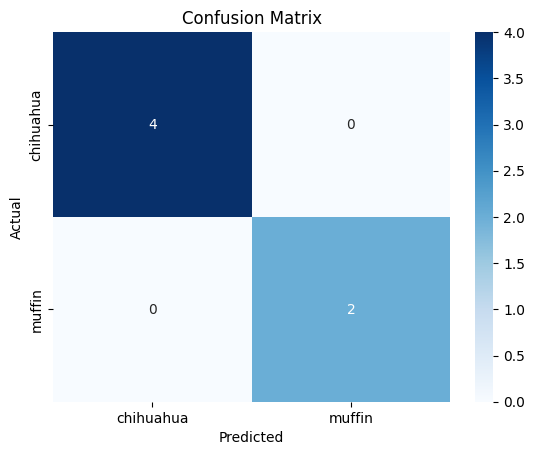

In [ ]:

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert string labels to numbers
le = LabelEncoder()
y_true = le.fit_transform(labels)  # 'chihuahua' → 0, 'muffin' → 1 (or vice versa)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_true, test_size=0.3, random_state=42)

# Step 3: Train a classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Step 4: Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"🎯 Classifier Accuracy: {acc:.2f}")

# Step 5: Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


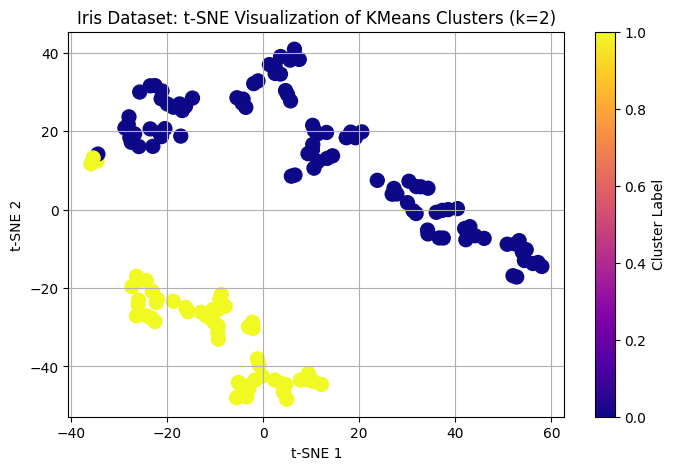

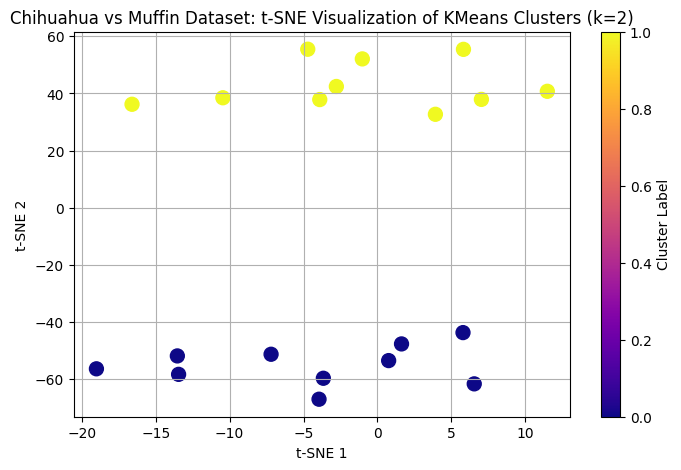

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

def plot_tsne_clusters(X_tsne, features, k=None,
                       wcss_scores=None, sil_scores=None, db_scores=None,
                       title_prefix=""):
    if k is None:
        if not (wcss_scores and sil_scores and db_scores):
            raise ValueError("If k is not provided, you must pass WCSS, silhouette, and DB scores.")
        k = find_best_k(wcss_scores, sil_scores, db_scores)

    cluster_labels = KMeans(n_clusters=k, random_state=42).fit_predict(features)

    plt.figure(figsize=(8, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='plasma', s=100)
    plt.title(f"{title_prefix}t-SNE Visualization of KMeans Clusters (k={k})")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(label='Cluster Label')
    plt.grid(True)
    plt.show()

    return cluster_labels

labels_by_dataset = {}

for dataset_name, X in datasets:
    X_tsne = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(X)


    cluster_labels = plot_tsne_clusters(
        X_tsne=X_tsne,
        features=X,
        wcss_scores=all_metrics[dataset_name]["k_wcss"],
        sil_scores=all_metrics[dataset_name]["sil_scores"],
        db_scores=all_metrics[dataset_name]["db_scores"],
        title_prefix=f"{dataset_name}: "
    )
    labels_by_dataset[dataset_name] = cluster_labels

chichi_labels = labels_by_dataset["Chihuahua vs Muffin Dataset"]
plt.figure(figsize=(10, 4))




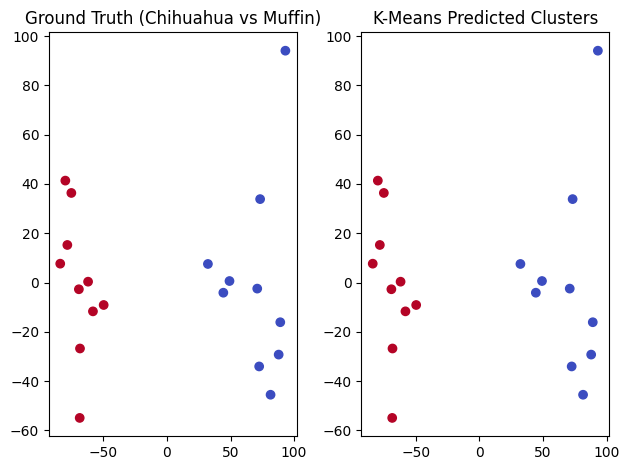

In [ ]:
# Ground truth visualization
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='coolwarm')
plt.title("Ground Truth (Chihuahua vs Muffin)")

# K-Means cluster visualization
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=chichi_labels , cmap='coolwarm')
plt.title("K-Means Predicted Clusters")

plt.tight_layout()
plt.show()



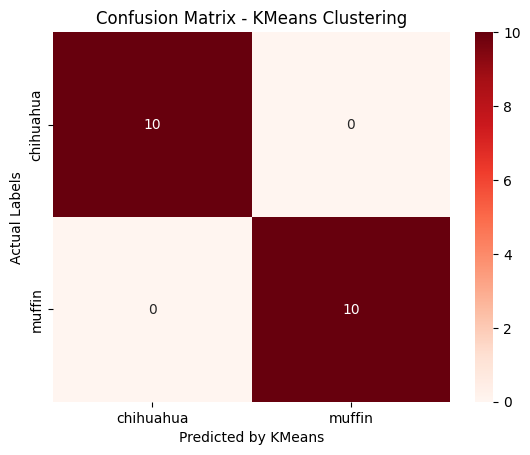

In [ ]:
from sklearn.metrics import confusion_matrix
cm_kmeans = confusion_matrix(y_true, chichi_labels)

sns.heatmap(cm_kmeans, annot=True, cmap='Reds', fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted by KMeans')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - KMeans Clustering')
plt.show()


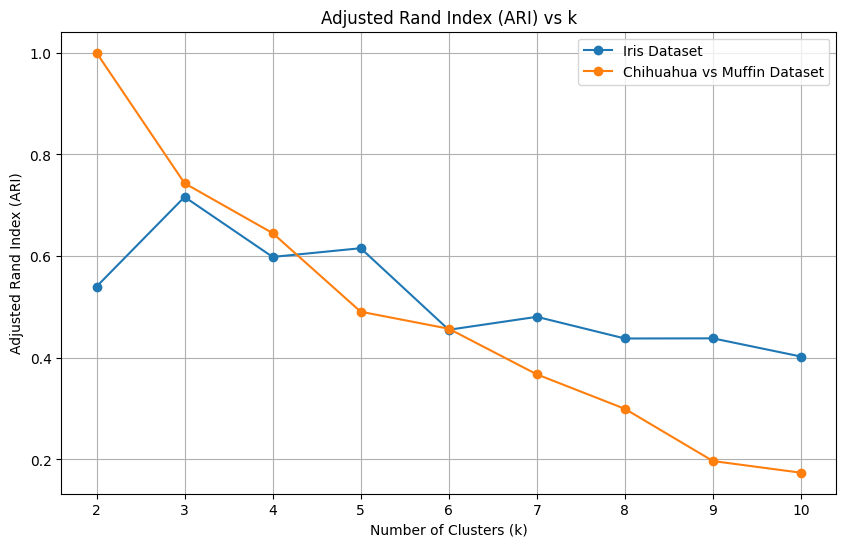

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

plt.figure(figsize=(10, 6))  # Make one figure

k_range = range(2, 11)  # k values from 2 to 10

for dataset_name, X in datasets:
    y_ref = iris_data.target if dataset_name == "Iris Dataset" else y_true  # Ground truth labels

    ari_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        cluster_labels = kmeans.labels_
        ari = adjusted_rand_score(y_ref, cluster_labels)
        ari_scores.append(ari)

    # Plot each dataset's line
    plt.plot(k_range, ari_scores, marker='o', label=dataset_name)

# Add labels and legend
plt.title("Adjusted Rand Index (ARI) vs k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.legend()
plt.grid(True)
plt.show()
